In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import median_filter
from matplotlib.gridspec import GridSpec

import matplotlib
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter

In [2]:
from functools import partial

## Define Functions

In [3]:
def load_signal_table(path: str):
    """Loads table and sets index according to expected columns "ID" and optional column "coordinate"

    Args:
        path (str): path to the input file in .csv/.tsv format. Supports zipped files.

    Returns:
        pandas.DataFrame: DataFrame containing loaded data.
    """
    ## determine dtypes
    if any([x in path for x in [".tsv", ".tsv.gz"]]):
        dtype_df = pd.read_csv(path, sep="\t", header=None, nrows=1000)
    else:
        dtype_df = pd.read_csv(path, header=None, nrows=1000)

    non_numeric = dtype_df.select_dtypes(exclude=["float", "int"]).columns
    numeric = dtype_df.select_dtypes(include=["float", "int"]).columns
    dtype_dict = {key: str for key in non_numeric.values}
    dtype_dict.update({col: np.float32 for col in numeric if col not in non_numeric})
    del dtype_df
    ## load actual data
    if any([x in path for x in [".tsv", ".tsv.gz"]]):
        df = pd.read_csv(path, sep="\t", header=None, dtype=dtype_dict)
    else:
        df = pd.read_csv(path, header=None, dtype=dtype_dict)
    if pd.api.types.is_string_dtype(df[0]):
        if pd.api.types.is_string_dtype(df[1]):
            df = df.set_index([0, 1])
            df.index.names = ["ID", "coordinate"]
        else:
            df = df.set_index(0)
            df.index.name = "ID"
    return df

In [4]:
def load_bias_table(path: str):
    df = pd.read_csv(path, sep="\t", index_col=[0, 1])
    return df

In [5]:
def calculate_flanking_regions(val: int):
    """Calculates flanking regions for point of interest.
    Args:
        val (int): should be length of value vector
    Raises:
        TypeError: Only integers are allowed
    Returns:
        [iterator]: range of values around center point (e.g. range(-1000,1000))
    """

    if not isinstance(val, int):
        raise TypeError("Only integers are allowed")

    if val % 2 == 0:
        flank = int(val / 2)
        region = range(-flank, flank)
    elif val % 2 == 1:
        flank_l = int(val / 2 - 0.5)
        flank_r = int(val / 2 + 0.5)
        region = range(-flank_l, flank_r)
    return region


def get_window_slice(window, width=1):
    """Generates upper and lower limits of a specified window from the center point for slicing data.

    Args:
        window (int): size of a window (e.g. 5000)
        width (int, optional): width of the window around the window center. Defaults to 1.

    Returns:
        tuple: upper and lower limits of a slice
    """
    halfwidth = width / 2
    center = window / 2
    start = center - halfwidth
    stop = center + halfwidth
    return int(start), int(stop)

In [6]:
def process_sample(
    sample: pd.DataFrame,
    overlay_mode: str = "mean",
    smoothing: bool = False,
    smooth_window: int = 21,
    smooth_polyorder: int = 2,
    scaling: bool = False,
    rolling: bool = False,
    rolling_window: int = 1000,
    edge_norm: bool = False,
    window: int = 1000,
    flank:int = 500,
) -> pd.DataFrame:
    """Process sample for plotting. This includes smoothing, normalization and the removal of edge regions to mitigate edge effects.

    Args:
        sample (pd.DataFrame): Sample signal extracted from cfDNA.
        overlay_mode (str, optional): Mode for aggregating signal over multiple regions. Can be mean, median or confidence interval. Defaults to "mean".
        smoothing (bool, optional): Switch on whether the signal should be smoothed. Defaults to False.
        smooth_window (int, optional): Smoothing window for Savitzky-Golay filter. Defaults to 21.
        smooth_polyorder (int, optional): Order of polynomial used in Savitzky-Golay filter. Defaults to 2.
        scaling (bool, optional): Switch on whether the signal should be standardized. Defaults to False.
        rolling (bool, optional): Switch on whether the signal should be demeaned by substracting the rolling median. Defaults to False.
        rolling_window (int, optional): Window size being used in rolling_window demeaning.
        edge_norm (bool, optional): Switch on whether the signal should be demeaned by substracting the average signal in the flanking regions. Defaults to False.
        window (int, optional): Size of window centered on region of interest. Defaults to 1000.
        flank (int, optional): Size of flanking regions for edge_norm. Defaults to 500.

    Raises:
        ValueError: Invalid overlay_mode keyword.

    Returns:
        pd.DataFrame: Processed sample.
    """

    #print(locals())
    if window % 2 == 0:
        fstart = int(window / 2 + 1)
        fstop = int(-window / 2)
    elif window % 2 == 1:
        fstart = int(window / 2 - 0.5 + 1)
        fstop = int(-window / 2 + 0.5)



    if edge_norm:
        flank_start, flank_end = get_window_slice(len(sample.columns),flank*2)

        helper = abs(
            sample.iloc[:, flank_start:flank_end].mean(axis=1)
        )
        if (helper==0).any():
            zero_mask = (helper==0)
            print(f"Regions with zero mean in Normalization slice [{flank_start}, {flank_end}] encountered. Removing respective regions.")
            for zero_region in zero_mask[zero_mask].index:
                print(f"Removing region: {zero_region}")
            helper.drop(helper[zero_mask].index, inplace=True)
            sample.drop(sample[zero_mask].index, inplace=True)
        sample = sample.div(helper, axis=0)

    if smoothing:
        sample = sample.apply(
            lambda x: savgol_filter(
                x, window_length=smooth_window, polyorder=smooth_polyorder
            ),
            axis=1,
            result_type="broadcast",
        )
             
    if overlay_mode.lower() == "mean":
        sample = pd.DataFrame(sample.mean(numeric_only=True))
    elif overlay_mode.lower() == "median":
        sample = pd.DataFrame(sample.median(numeric_only=True))
    else:
        raise ValueError(f"{overlay_mode} is not a valid keyword.")
   
        
    if rolling:
        if edge_norm:
            trend = sample.rolling(rolling_window, center=True, min_periods=1).median()
            sample = sample.div(trend)
        else:
            flank_start, flank_end = get_window_slice(len(sample),flank*2)
            norm_sample = sample.div(sample.iloc[flank_start:flank_end].mean())
            trend = norm_sample.rolling(rolling_window, center=True, min_periods=1).median()
            sample = sample.div(trend)
        
            
    sample["position"] = calculate_flanking_regions(len(sample))
    sample = sample.set_index("position")
    
    #sample = sample.iloc[fstop:fstart, :]

    return sample

In [7]:
def prepare_signal_plotting(sample,display_window=(-1500,1500), name=None):
    processed_sample = process_sample_partial(sample=sample)
    
    if name:
        processed_sample.rename(columns={0:name},inplace=True)
    
    sample_min = processed_sample.index.min()
    sample_max = processed_sample.index.max()
    
    sample_lower = max(sample_min, display_window[0])
    sample_upper = min(sample_max, display_window[1])
    
    
    processed_sample = processed_sample.loc[sample_lower:sample_upper]
    return processed_sample

In [8]:
#should return an ax
def plot_GC_overlay(
    cases: pd.DataFrame,
    controls: pd.DataFrame,
    figsize: tuple = (12, 9),
    ax=None,
    signal: str = "Coverage",
    title: str = None,
    lower_limit:float = None,
    upper_limit: float = None,
    legend=False
):
    
    if ax is None:
        # checks for provided ax, creates a new figure if none was provided. This is necessary, because otherwise MPL will reuse the previos figure.
        fig = plt.figure(figsize=figsize)
        if title:
            fig.suptitle(title)
        ax = plt.gca()
    else:
        if title:
            ax.set_title(title) #, fontsize=16)
    
    ylab = f"Normalized {signal}"

    #fig, ax = plt.subplots(1, 1, figsize=figsize)


    for col in controls:
        ax.plot(controls[col], label=col) #, color="black", alpha=0.7)

    for col in cases:
        ax.plot(cases[col], label=col) #, alpha=0.7)

    ax.set_xlabel("Position relative to target site [bp]") #, fontsize=14)
    ax.set_ylabel(ylab) #, fontsize=14)

    if lower_limit or upper_limit:
        shared_ylim = ax.get_ylim()
        if lower_limit:
            shared_ylim = ( min(shared_ylim[0], lower_limit), shared_ylim[1])
        if upper_limit:
            shared_ylim = ( shared_ylim[0], max(shared_ylim[1], upper_limit) )
        
        ax.set_ylim(shared_ylim)

    
    if legend:
        if len(ax.get_legend_handles_labels()[1]) < 15:
            ax.legend(bbox_to_anchor=(1, 0.95), loc="upper left")
        else:
            ax.legend(bbox_to_anchor=(1, 0.95), loc="upper left", ncol=2)

    return ax

In [36]:
def plot_GCbias_heatmap(df, title=None, figsize=(35, 30), filter=None, quantile_threshold=None, ax=None):
    if ax is None:
        # checks for provided ax, creates a new figure if none was provided. This is necessary, because otherwise MPL will reuse the previos figure.
        fig = plt.figure(figsize=figsize)
        if title:
            fig.suptitle(title)
        ax = plt.gca()
    else:
        if title:
            ax.set_title(title)
    
    R_GC = df.loc["R_gc"]
    R_GC = R_GC.replace(0.0,1.0)
    
    # calculate min,max values for coloring
    if quantile_threshold:
        R_GC_min, R_GC_max = np.nanmin(R_GC), np.quantile(R_GC, quantile_threshold)
    else:
        R_GC_min, R_GC_max = np.nanmin(R_GC), np.nanmax(R_GC)
    
    # create plots
    bias = ax.pcolormesh(
        R_GC.columns,
        R_GC.index,
        R_GC.values,
        cmap="viridis",
        vmin=R_GC_min,
        vmax=R_GC_max,
        rasterized=True
    )
    ax.set_ylabel("fragment length")
    ax.set_xticks(
        ticks=np.arange(
            min(R_GC.columns.astype(int)), max(R_GC.columns.astype(int)) + 1, 10
        )
    )
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xlabel("GC content [%]")
    
    plt.colorbar(bias, label="GC bias ratio", format=lambda x, _: f"{x:.1f}") #bias, cax=fig.axes[1], ticklocation="left", label="GC bias ratio")
    
    return ax

## Define Parameters

In [10]:
# processing parameters
overlay_mode = "mean" # Can be either "mean" or "median". Sets overlay mode, specifying how regions should be aggregated for each sample.
smoothing = True # Activates smoothing with Savitzky-Golay filter.
smooth_window = 21 # Sets windows size used for smoothing with Savitzky-Golay filter.
smooth_polyorder = 2 # Sets order of polynomial used for smoothing with Savitzky-Golay filter.
rolling = True # Activates trend removal with a rolling median filter.
rolling_window = 1000 # Sets window size used in rolling median filter.
flank_norm = True # Activates normalization by dividing the signals by the mean coverage in flanking intervals around the region of interest.
flank = 2000 # Sets the size of the flanking intervals around the region of interest. Should be <= 0.5 of the extracted signals
signal = "Coverage" # can be either "coverage" or "WPS"
display_window = (-1500,1500)


In [11]:
process_sample_partial = partial(process_sample,
    overlay_mode = overlay_mode,
    smoothing = smoothing,
    smooth_window = smooth_window,
    smooth_polyorder = smooth_polyorder,
    rolling = rolling,
    rolling_window = rolling_window,
    edge_norm = flank_norm,
    flank = flank,
)

In [12]:
# plotting parameters
figsize = (12, 9)

In [13]:
# samples
H01_bias_file = "../../results/manuscript_samples/GCBias/bias_table/H01-GCbias_repeatmasker.hg38.tsv.gz"
P01_bias_file = "../../results/manuscript_samples/GCBias/bias_table/P01-GCbias_repeatmasker.hg38.tsv.gz"
B01_bias_file = "../../results/manuscript_samples/GCBias/bias_table/B01-GCbias_repeatmasker.hg38.tsv.gz"
H01_LYL1_raw_file = "../../results/manuscript_samples/signals/signal-uncorrected/LYL1.H01-uncorrected_COV.hg38.csv.gz"
P01_LYL1_raw_file = "../../results/manuscript_samples/signals/signal-uncorrected/LYL1.P01-uncorrected_COV.hg38.csv.gz"
B01_LYL1_raw_file = "../../results/manuscript_samples/signals/signal-uncorrected/LYL1.B01-uncorrected_COV.hg38.csv.gz"
H01_LYL1_corrected_file = "../../results/manuscript_samples/signals/signal-corrected/LYL1.H01-corrected_COV.hg38.csv.gz"
P01_LYL1_corrected_file = "../../results/manuscript_samples/signals/signal-corrected/LYL1.P01-corrected_COV.hg38.csv.gz"
B01_LYL1_corrected_file = "../../results/manuscript_samples/signals/signal-corrected/LYL1.B01-corrected_COV.hg38.csv.gz"
H01_GRHL2_corrected_file = "../../results/manuscript_samples/signals/signal-corrected/GRHL2.H01-corrected_COV.hg38.csv.gz"
P01_GRHL2_corrected_file = "../../results/manuscript_samples/signals/signal-corrected/GRHL2.P01-corrected_COV.hg38.csv.gz"
B01_GRHL2_corrected_file = "../../results/manuscript_samples/signals/signal-corrected/GRHL2.B01-corrected_COV.hg38.csv.gz"

## load data

In [15]:
H01_LYL1_raw_input = load_signal_table(H01_LYL1_raw_file)
H01_LYL1_corr_input = load_signal_table(H01_LYL1_corrected_file)
H01_bias_input = load_bias_table(H01_bias_file)

In [16]:
B01_LYL1_raw_input = load_signal_table(B01_LYL1_raw_file)
B01_LYL1_corr_input = load_signal_table(B01_LYL1_corrected_file)
B01_bias_input = load_bias_table(B01_bias_file)

In [17]:
P01_LYL1_raw_input = load_signal_table(P01_LYL1_raw_file)
P01_LYL1_corr_input = load_signal_table(P01_LYL1_corrected_file)
P01_bias_input = load_bias_table(P01_bias_file)

In [18]:
H01_GRHL2_corr_input = load_signal_table(H01_GRHL2_corrected_file)
B01_GRHL2_corr_input = load_signal_table(B01_GRHL2_corrected_file)
P01_GRHL2_corr_input = load_signal_table(P01_GRHL2_corrected_file)

### prepare for plotting

In [19]:
H01_LYL1_raw = prepare_signal_plotting(sample=H01_LYL1_raw_input, name="uncorrected")
H01_LYL1_corr = prepare_signal_plotting(sample=H01_LYL1_corr_input, name="corrected")

In [20]:
B01_LYL1_raw = prepare_signal_plotting(sample=B01_LYL1_raw_input, name="uncorrected")
B01_LYL1_corr = prepare_signal_plotting(sample=B01_LYL1_corr_input, name="corrected")

Regions with zero mean in Normalization slice [3100, 7100] encountered. Removing respective regions.
Removing region: ('LYL1', 'chr1:169255557-169265757')
Regions with zero mean in Normalization slice [3100, 7100] encountered. Removing respective regions.
Removing region: ('LYL1', 'chr1:169255557-169265757')


In [21]:
P01_LYL1_raw = prepare_signal_plotting(sample=P01_LYL1_raw_input, name="uncorrected")
P01_LYL1_corr = prepare_signal_plotting(sample=P01_LYL1_corr_input, name="corrected")

In [22]:
H01_GRHL2_corr = prepare_signal_plotting(sample=H01_GRHL2_corr_input, name="corrected")
B01_GRHL2_corr = prepare_signal_plotting(sample=B01_GRHL2_corr_input, name="corrected")
P01_GRHL2_corr = prepare_signal_plotting(sample=P01_GRHL2_corr_input, name="corrected")

Regions with zero mean in Normalization slice [3100, 7100] encountered. Removing respective regions.
Removing region: ('GRHL2', 'chr6:32494822-32505022')
Regions with zero mean in Normalization slice [3100, 7100] encountered. Removing respective regions.
Removing region: ('GRHL2', 'chr6:32494822-32505022')
Regions with zero mean in Normalization slice [3100, 7100] encountered. Removing respective regions.
Removing region: ('GRHL2', 'chr6:32494822-32505022')
Removing region: ('GRHL2', 'chr6:32533064-32543264')
Removing region: ('GRHL2', 'chr6:32557996-32568196')


### plot Fig 1

In [23]:
fig1_layout = [['A_overlay', 'A_overlay', 'A_bias'],
              ['B_overlay', 'B_overlay', 'B_bias'],
              ['C_overlay', 'C_overlay', 'C_bias'],]

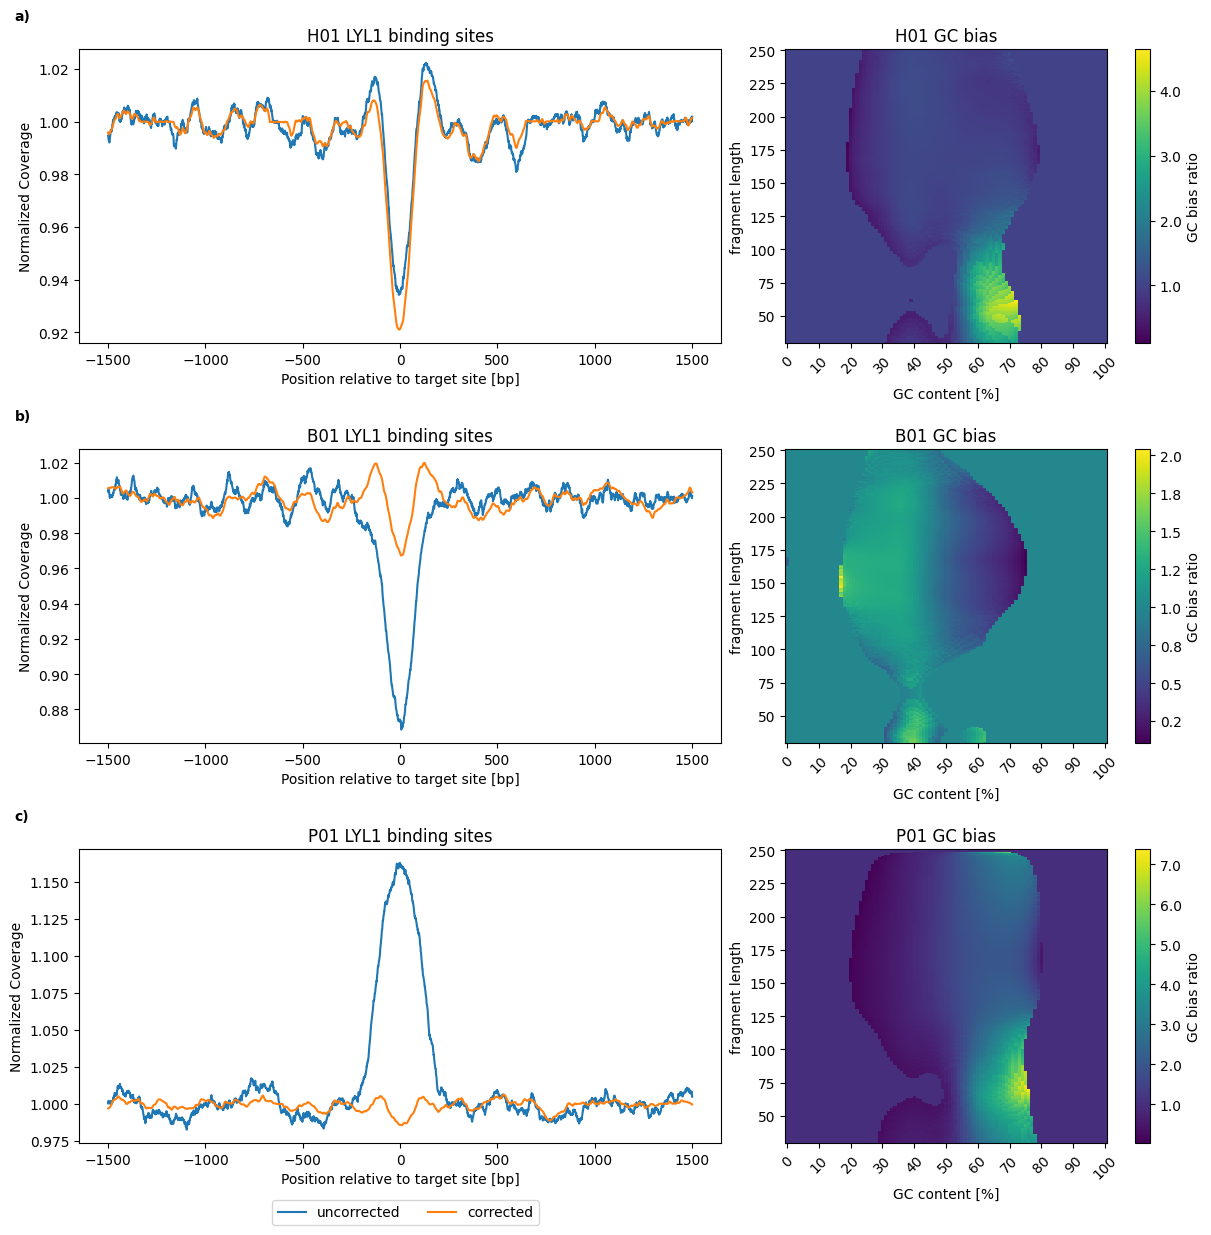

In [37]:
fig1, axs1 = plt.subplot_mosaic(fig1_layout,layout='constrained', figsize=(12,12))
# Overlay plots
healthy_overlay = plot_GC_overlay(cases=H01_LYL1_corr, controls=H01_LYL1_raw, title="H01 LYL1 binding sites", ax=axs1["A_overlay"])
bcancer_overlay = plot_GC_overlay(cases=B01_LYL1_corr, controls=B01_LYL1_raw, title="B01 LYL1 binding sites", ax=axs1["B_overlay"])
pcancer_overlay = plot_GC_overlay(cases=P01_LYL1_corr, controls=P01_LYL1_raw, title="P01 LYL1 binding sites", ax=axs1["C_overlay"])
# Annotate subfigures
axs1["A_overlay"].text(-0.1, 1.1, "a)", transform=axs1["A_overlay"].transAxes, weight='bold') #, size=20)
axs1["B_overlay"].text(-0.1, 1.1, "b)", transform=axs1["B_overlay"].transAxes, weight='bold') #, size=20)
axs1["C_overlay"].text(-0.1, 1.1, "c)", transform=axs1["C_overlay"].transAxes, weight='bold') #, size=20)
# GC bias plots
healthy_GCbias = plot_GCbias_heatmap(H01_bias_input, title="H01 GC bias", ax=axs1["A_bias"])
bcancer_GCbias = plot_GCbias_heatmap(B01_bias_input, title="B01 GC bias", ax=axs1["B_bias"])
pcancer_GCbias = plot_GCbias_heatmap(P01_bias_input, title="P01 GC bias", ax=axs1["C_bias"])

handles, labels = axs1["A_overlay"].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig1.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.45, 0.01),ncol=2)

### Case Control plots for LYL1 and GRHL2

In [38]:
#should return an ax
def plot_case_control_overlay(
    df: pd.DataFrame,
    figsize: tuple = (12, 9),
    ax=None,
    signal: str = "Coverage",
    title: str = None,
    lower_limit:float = None,
    upper_limit: float = None,
    legend=False
):
    
    if ax is None:
        # checks for provided ax, creates a new figure if none was provided. This is necessary, because otherwise MPL will reuse the previos figure.
        fig = plt.figure(figsize=figsize)
        if title:
            fig.suptitle(title)
        ax = plt.gca()
    else:
        if title:
            ax.set_title(title) #, fontsize=16)
    
    ylab = f"Normalized {signal}"

    #fig, ax = plt.subplots(1, 1, figsize=figsize)


    for col in df:
        ax.plot(df[col], label=col) #, alpha=0.7)

    ax.set_xlabel("Position relative to target site [bp]") #, fontsize=14)
    ax.set_ylabel(ylab) #, fontsize=14)

    if lower_limit or upper_limit:
        shared_ylim = ax.get_ylim()
        if lower_limit:
            shared_ylim = ( min(shared_ylim[0], lower_limit), shared_ylim[1])
        if upper_limit:
            shared_ylim = ( shared_ylim[0], max(shared_ylim[1], upper_limit) )
        
        ax.set_ylim(shared_ylim)

    
    if legend:
        if len(ax.get_legend_handles_labels()[1]) < 15:
            ax.legend(bbox_to_anchor=(1, 0.95), loc="upper left")
        else:
            ax.legend(bbox_to_anchor=(1, 0.95), loc="upper left", ncol=2)

    return ax

In [26]:
LYL1_df = pd.DataFrame()
LYL1_df["healthy"] = H01_LYL1_corr
LYL1_df["prostate cancer"] = B01_LYL1_corr
LYL1_df["breast cancer"] = P01_LYL1_corr

In [27]:
GRHL2_df = pd.DataFrame()
GRHL2_df["healthy"] = H01_GRHL2_corr
GRHL2_df["prostate cancer"] = B01_GRHL2_corr
GRHL2_df["breast cancer"] = P01_GRHL2_corr

In [28]:
fig2_layout = [['LYL1_overlay'],
              ['GRHL2_overlay',],]

Text(-0.1, 1.1, 'b)')

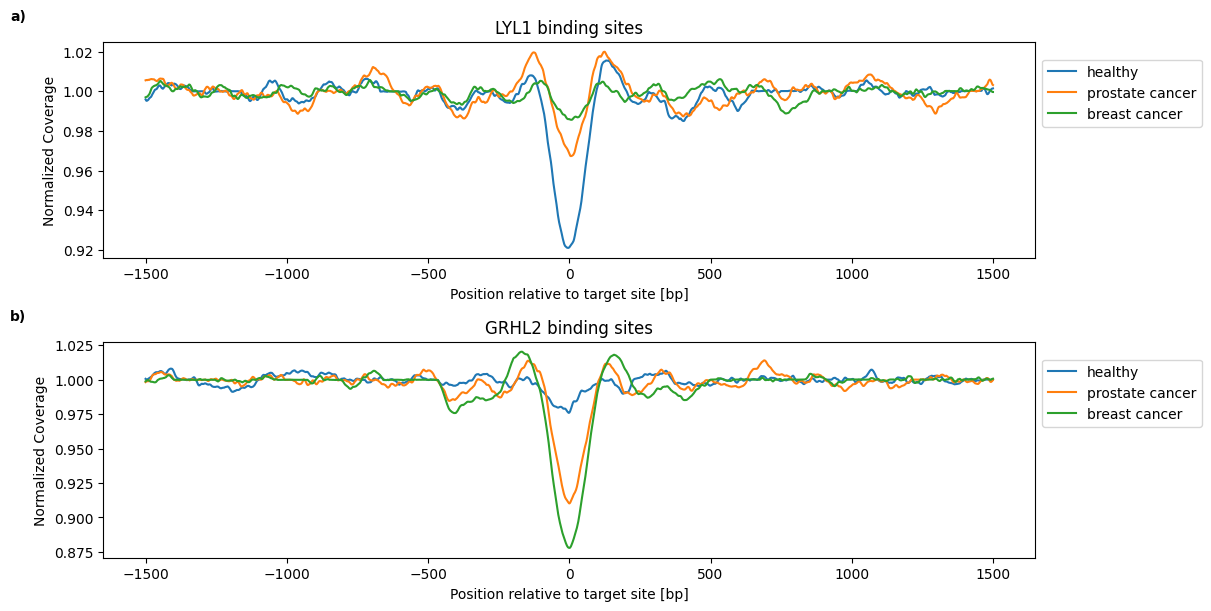

In [39]:
fig2, axs2 = plt.subplot_mosaic(fig2_layout,layout='constrained', figsize=(12,6))
# Overlay plots
LYL1_overlay = plot_case_control_overlay(df=LYL1_df, title="LYL1 binding sites", ax=axs2['LYL1_overlay'], legend=True)
GRHL2_overlay = plot_case_control_overlay(df=GRHL2_df, title="GRHL2 binding sites", ax=axs2['GRHL2_overlay'], legend=True)
# Annotate subfigures
axs2['LYL1_overlay'].text(-0.1, 1.1, "a)", transform=axs2['LYL1_overlay'].transAxes, weight='bold') #, size=20)
axs2['GRHL2_overlay'].text(-0.1, 1.1, "b)", transform=axs2['GRHL2_overlay'].transAxes, weight='bold') #, size=20)

In [41]:
fig1.savefig("cfDNA_Uniflow_publication/Fig2.png", bbox_inches="tight", dpi=600)
fig1.savefig("cfDNA_Uniflow_publication/Fig2.pdf", bbox_inches="tight", dpi=600)

In [34]:
fig2.savefig("cfDNA_Uniflow_publication/Fig3.png", bbox_inches="tight", dpi=600)
fig2.savefig("cfDNA_Uniflow_publication/Fig3.pdf", bbox_inches="tight")